# View Sod Shock Tube Results

In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
sys.path.append('/Users/smil/Projects/cato/scripts/')
from load_datasets import read_1d_dataset
sns.set_context('talk')

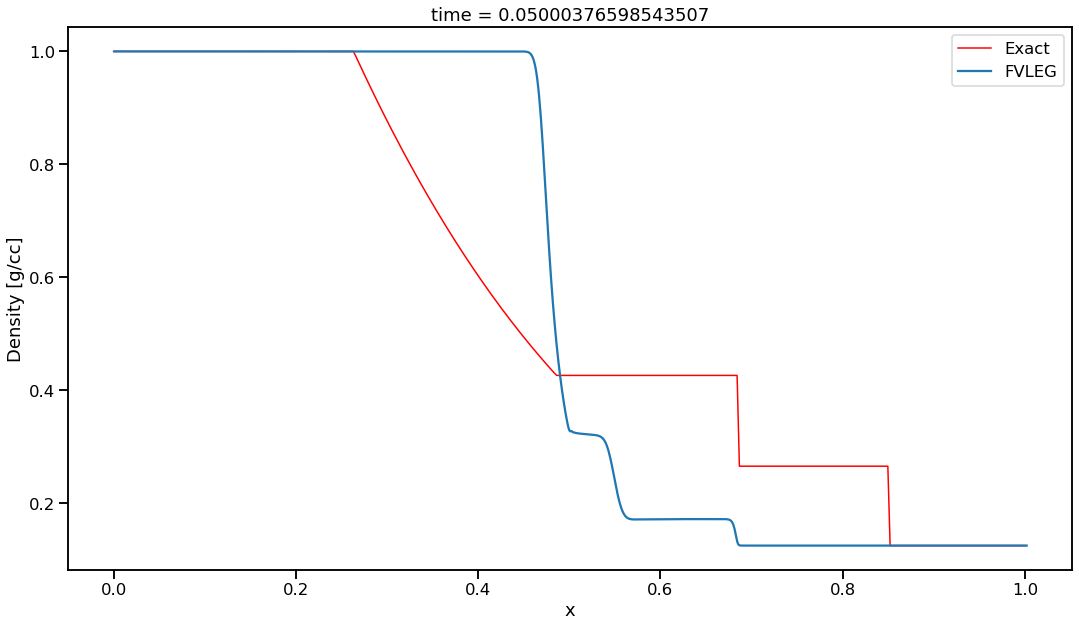

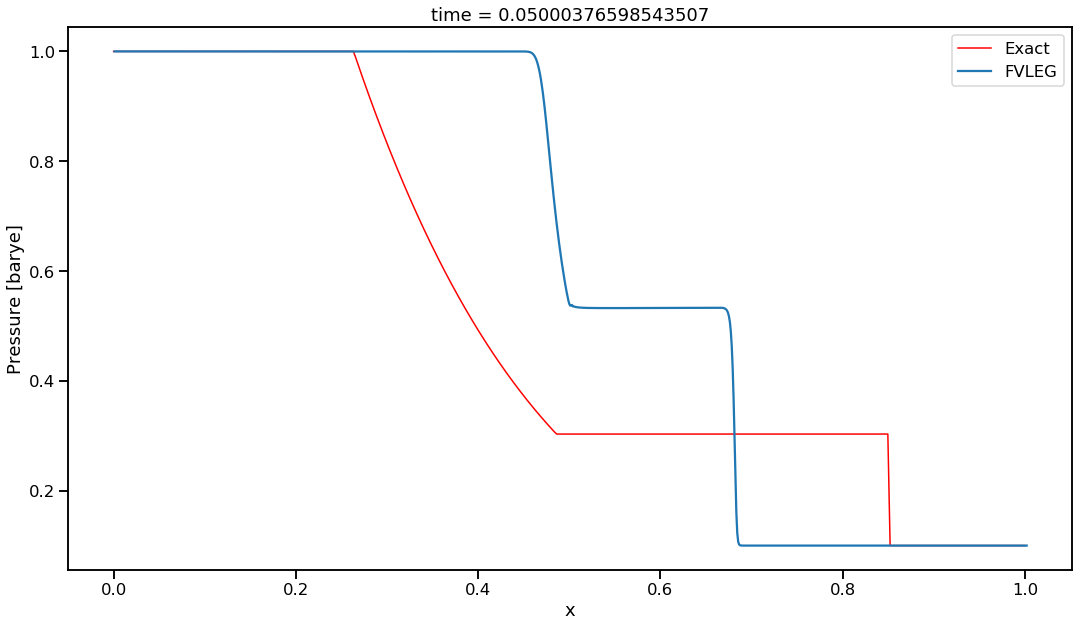

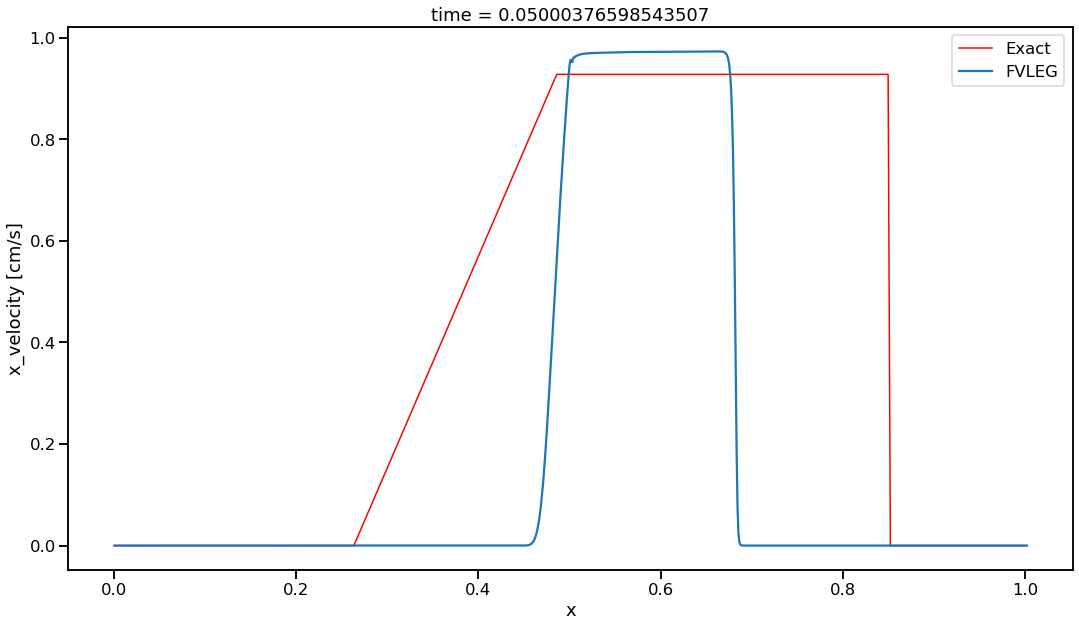

In [208]:
t = 0.2

import sod
import matplotlib.pyplot as plt
gamma = 1.4
npts = 400

positions, regions, values = sod.solve(left_state= (1,       1, 0), 
                                       right_state=(0.1, 0.125, 0.),
                                       geometry=(0., 1., 0.5), 
                                       t=t, gamma=gamma, npts=npts)

p = values['p']
rho = values['rho']
u = values['u']

# Energy and temperature
E = p/(gamma-1.) + 0.5*u**2
T = p/rho


plt.figure(figsize=(18,10))
plt.plot(values['x'], rho, linewidth=1.5, color='r', label='Exact')
plt.ylabel('density')

ds = read_1d_dataset(folder='.', units='cgs')
ds.Density.sel(time=t, method='nearest').plot(label='FVLEG')
plt.legend()
plt.show()

plt.figure(figsize=(18,10))
plt.plot(values['x'], p, linewidth=1.5, color='r', label='Exact')
plt.ylabel('pressure')

ds.Pressure.sel(time=t, method='nearest').plot(label='FVLEG')
plt.legend()
plt.show()

plt.figure(figsize=(18,10))
plt.plot(values['x'], u, linewidth=1.5, color='r', label='Exact')
plt.ylabel('density')

ds.x_velocity.sel(time=t, method='nearest').plot(label='FVLEG')
plt.legend()
plt.show()

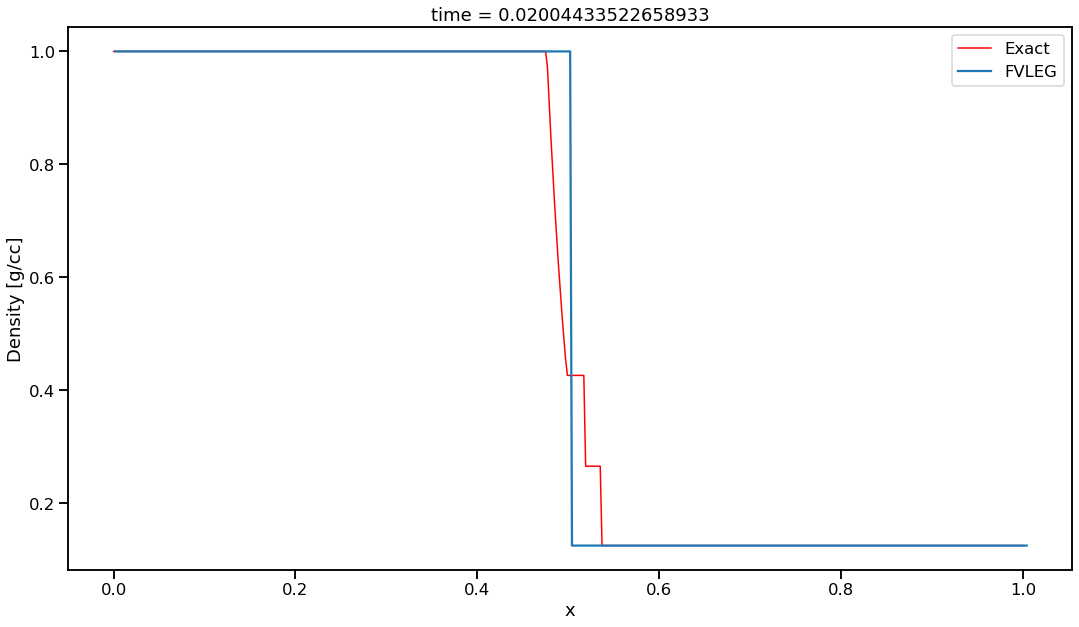

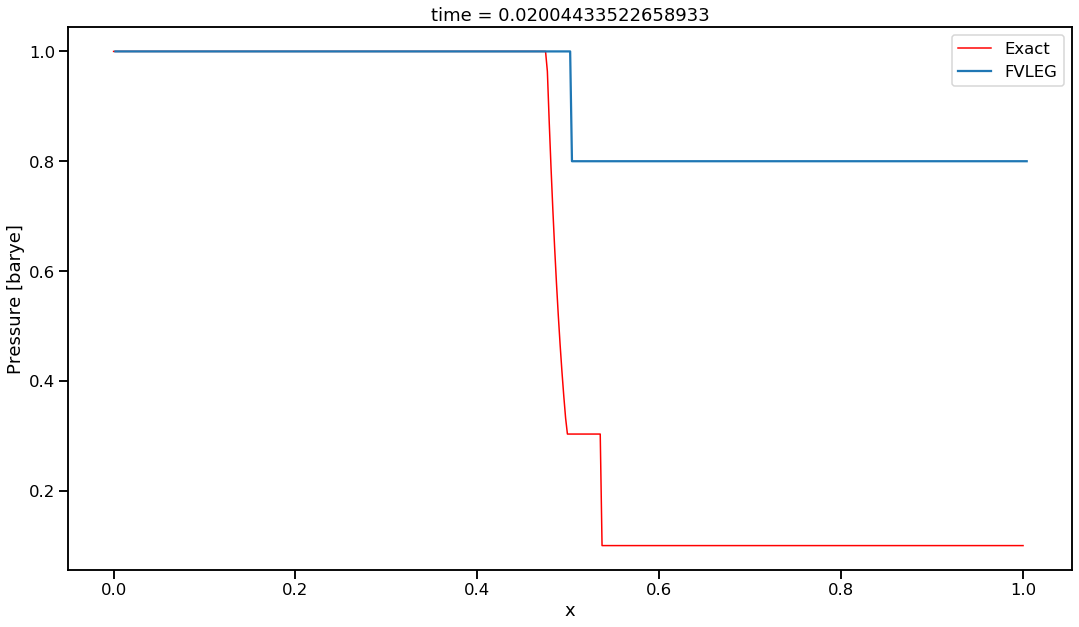

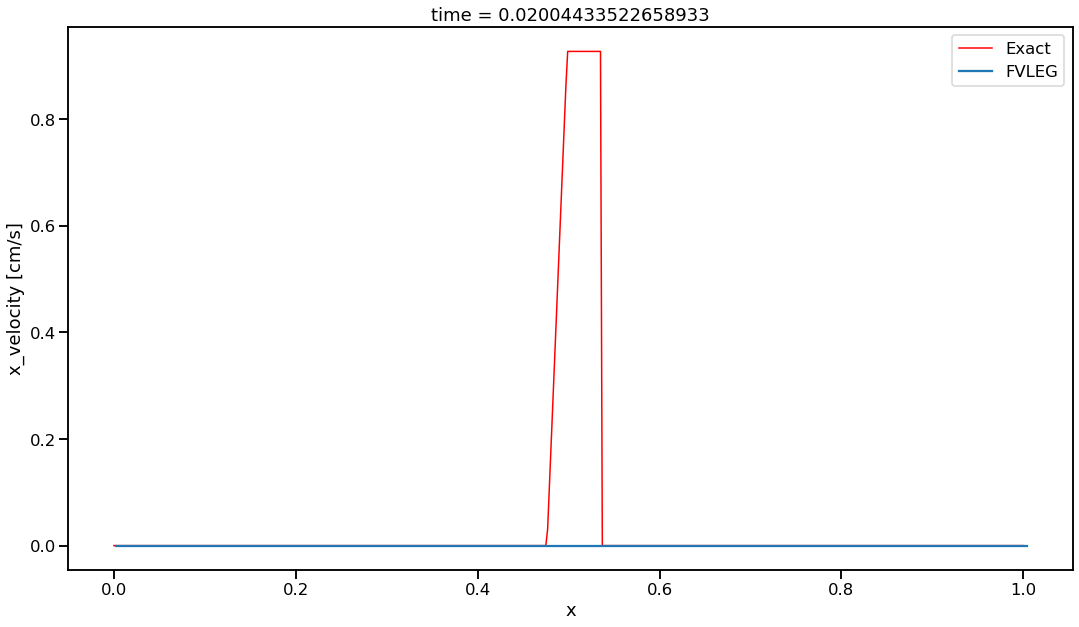

In [176]:
t = 0.02011426

import sod
import matplotlib.pyplot as plt
gamma = 1.4
npts = 500

positions, regions, values = sod.solve(left_state= (1,       1, 0), 
                                       right_state=(0.1, 0.125, 0.),
                                       geometry=(0., 1., 0.5), 
                                       t=t, gamma=gamma, npts=npts)

p = values['p']
rho = values['rho']
u = values['u']

# Energy and temperature
E = p/(gamma-1.) + 0.5*u**2
T = p/rho


plt.figure(figsize=(18,10))
plt.plot(values['x'], rho, linewidth=1.5, color='r', label='Exact')
plt.ylabel('density')

ds = read_1d_dataset(folder='.', units='cgs')
ds.Density.sel(time=t, method='nearest').plot(label='FVLEG')
plt.legend()
plt.show()

plt.figure(figsize=(18,10))
plt.plot(values['x'], p, linewidth=1.5, color='r', label='Exact')
plt.ylabel('pressure')

ds.Pressure.sel(time=t, method='nearest').plot(label='FVLEG')
plt.legend()
plt.show()

plt.figure(figsize=(18,10))
plt.plot(values['x'], u, linewidth=1.5, color='r', label='Exact')
plt.ylabel('density')

ds.x_velocity.sel(time=t, method='nearest').plot(label='FVLEG')
plt.legend()
plt.show()

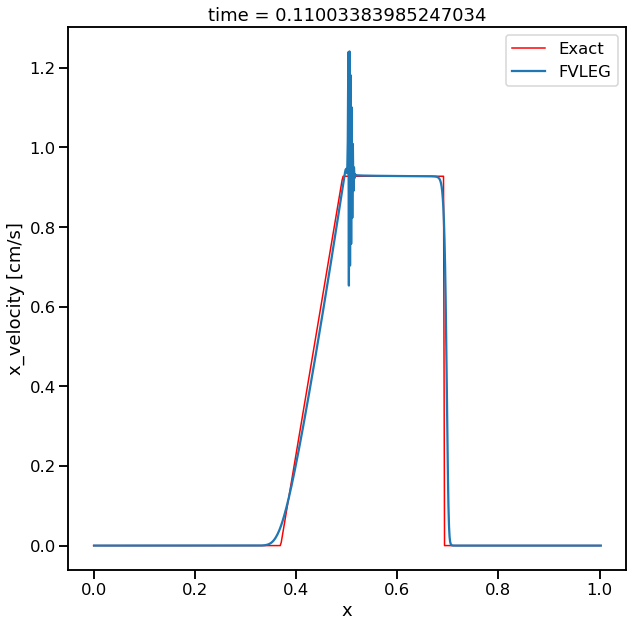

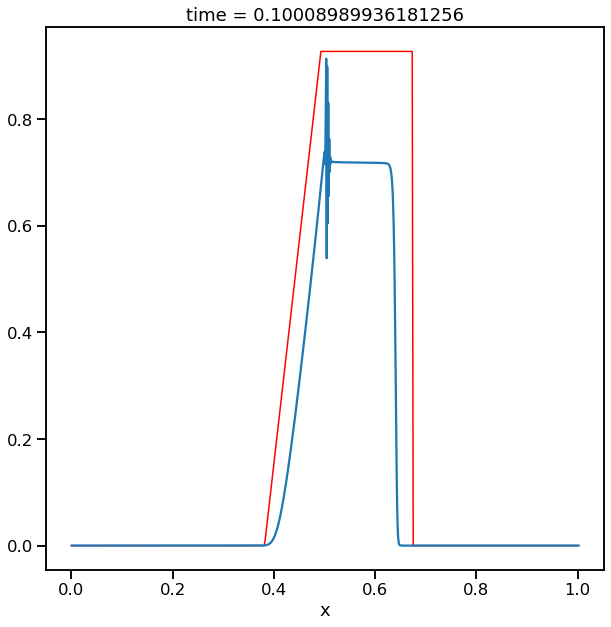

In [97]:
plt.figure(figsize=(10,10))
plt.plot(values['x'], u, linewidth=1.5, color='r', label='Exact')
plt.ylabel('density')

ds = read_1d_dataset(folder='.', units='cgs')
(ds['x_velocity']/ds.Density).sel(time=0.1, method='nearest').plot()

plt.show()

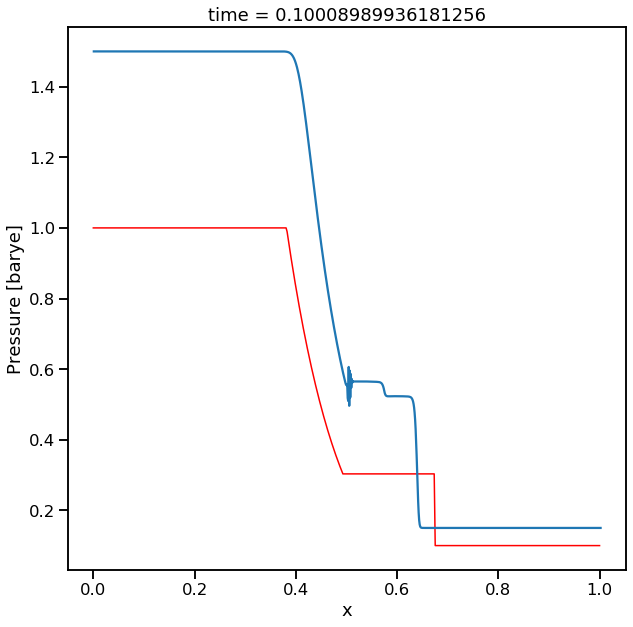

In [93]:
plt.figure(figsize=(10,10))
plt.plot(values['x'], p, linewidth=1.5, color='r', label='Exact')
plt.ylabel('density')

ds = read_1d_dataset(folder='.', units='cgs')
ds.Pressure.sel(time=0.1, method='nearest').plot()

plt.show()

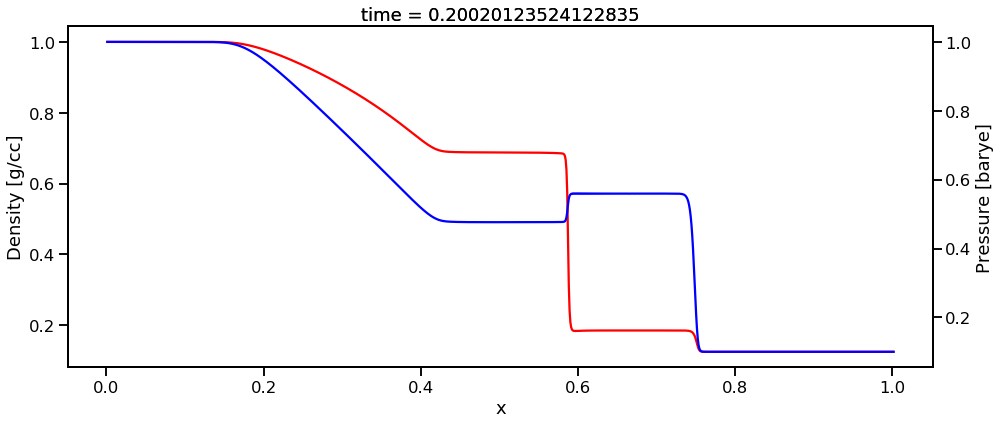

In [14]:
fig, rho_ax = plt.subplots(figsize=(14,6))
p_ax = rho_ax.twinx()

t=4

color = 'r'
ds.Density[t].plot(ax=rho_ax,color=color)
# rho_ax.set_ylabel('Density', color=color)
# rho_ax.tick_params(axis='y', labelcolor=color)

color='b'
ds.Pressure[t].plot(ax=p_ax,color=color)
# p_ax.set_ylabel('Pressure', color=color)
# p_ax.tick_params(axis='y', labelcolor=color)

# v_ax = rho_ax.twinx()
# color='k'
# ds.x_velocity[-1].plot(ax=v_ax, color=color)
# v_ax.set_ylabel('Velocity', color=color)
# v_ax.spines["right"].set_position(("axes", 1.05))
# v_ax.tick_params(axis='y', labelcolor=color)

# plt.xlim(.7,1)
# rho_ax.set_ylim(0,.1)
plt.tight_layout()
plt.show()


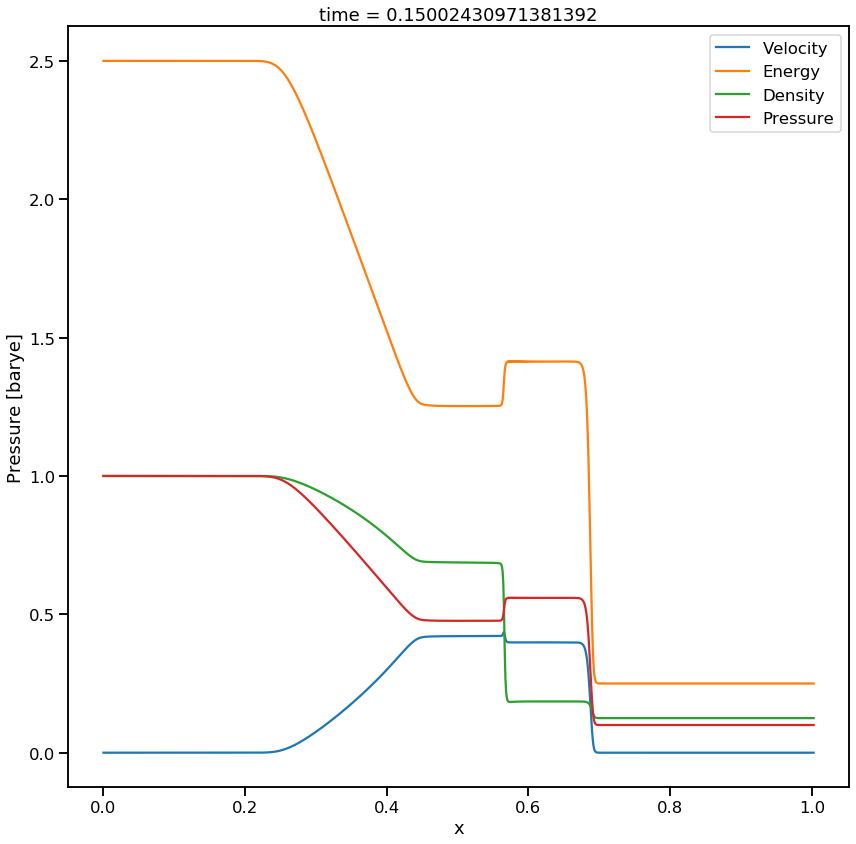

In [28]:
t = 3
plt.figure(figsize=(14,14))
ds.x_velocity[t].plot(label='Velocity')
ds.Energy[t].plot(label='Energy')
ds.Density[t].plot(label='Density')
ds.Pressure[t].plot(label='Pressure')
plt.legend()
plt.show()